In [1]:
%autosave 0

Autosave disabled


Regression on log1p without per area price

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold
from utilities import cal_score

In [3]:
stack_idx = '11'
models = '1-11,14-17'
use_test_kfold = set([2, 7, 8])

is_per_area = False

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
No. 0 file: model-01-lgb-cv.csv
No. 1 file: model-02-keras-search-cv.csv
No. 2 file: model-03-lgb-feats-selection-cv.csv
No. 3 file: model-04-lgb-PCA-cv.csv
No. 4 file: model-05-lgb-wo-per-area-cv.csv
No. 5 file: model-06-lgb-lr0.001-cv.csv
No. 6 file: model-07-keras-embedding-cv.csv
No. 7 file: model-08-keras-search-long-cv.csv
No. 8 file: model-09-lgb-feats-selection-75-cv.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-cv.csv
No. 10 file: model-11-rf-cv.csv
No. 11 file: model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
No. 12 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
No. 13 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
No. 14 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv


In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 12 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 13 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 14 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv


In [12]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_15,log_parea_pred_15,pred_16,log_pred_16,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.411432,12.182328,6.542462e+05,13.391241,12.162137,6.552449e+05,13.392766,12.163663,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.963920,13.567353,3.128284e+06,14.955995,13.559428,3.130186e+06,14.956603,13.560036,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.091430,14.371475,9.758797e+06,16.093680,14.373725,9.787304e+06,16.096597,14.376642,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.351229,13.743883,1.266868e+07,16.354644,13.747297,1.270893e+07,16.357815,13.750469,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.923267,12.378241,1.122232e+06,13.930831,12.385805,1.110012e+06,13.919882,12.374856,13.544637,11.999613


In [13]:
test.head()

,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_14,pred_15,log_pred_15,log_parea_pred_15,pred_16,log_pred_16,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.270289,1.476388e+07,16.507694,15.278587,1.388634e+07,16.446416,15.217310,1.449905e+07,16.489594,15.260487
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.144670,3.928353e+06,15.183731,13.139112,3.918650e+06,15.181258,13.136639,3.917960e+06,15.181082,13.136463
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.677153,1.062900e+07,16.179096,13.680076,1.073546e+07,16.189063,13.690042,1.063343e+07,16.179513,13.680493
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.815150,6.085773e+06,15.621464,14.809532,6.080935e+06,15.620669,14.808737,6.119193e+06,15.626941,14.815009
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.116189,1.061918e+06,13.875588,12.115326,1.072461e+06,13.885468,12.125206,1.084776e+06,13.896885,12.136623


### Check models scores

In [14]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-14 5908.873901
12 model-15 5900.873836
13 model-16 5907.874126
14 model-17 5905.874165


### Make Xy

In [15]:
if is_per_area:
    X = cv[['log_parea_pred_{}'.format(idx) for idx in idx_models]]
else:
    X = cv[['log_pred_{}'.format(idx) for idx in idx_models]]

if is_per_area:
    y = cv['log_parea_total_price']
else:
    y = cv['log_total_price']

### start regression

In [16]:
#reg = LassoCV(alphas=[0]+list(np.logspace(-4, 3, 7)), max_iter=100000, tol=1e-6, n_jobs=-1)
#reg.fit(X, y)

#print(reg.alpha_)
#print(reg.mse_path_)
#print(reg.coef_, reg.intercept_)

In [17]:
#for a in [0]+list(np.logspace(-4, 3, 7)):
#    reg_single = Lasso(alpha=a, max_iter=100000, tol=1e-6)
#    reg_single.fit(X, y)
#    print(reg_single.coef_, reg.intercept_)
#    print(reg_single.score(X,y))

In [18]:
alphas = [0, 0.00001, 0.00002, 0.00005, 0.00008, 0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.002, 0.005, 0.008, 0.01, 0.02]
gsearch = {}

folds = KFold(n_splits=3, shuffle=True, random_state=1208)
for i_fold, (itrain, ival) in enumerate(folds.split(X)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    X_train = X.iloc[itrain]
    X_val = X.iloc[ival]
    y_train = y.iloc[itrain]
    y_val = y.iloc[ival]
    
    # random sample - grid search
    for a in alphas:
        if a == 0:
            reg_single = LinearRegression()
        else:
            reg_single = Lasso(alpha=a, max_iter=100000, tol=1e-6)
        reg_single.fit(X_train, y_train)
        
        y_pred = reg_single.predict(X_val)
        if is_per_area:
            y_pred_final = np.expm1(y_pred) * cv.iloc[ival]['building_area']
            y_true_final = np.expm1(y_val) * cv.iloc[ival]['building_area']
        else:
            y_pred_final = np.expm1(y_pred)
            y_true_final = np.expm1(y_val)
        score = cal_score(y_true_final, y_pred_final)

        print('alpha, score:', a, score)
        gsearch[a] = gsearch.get(a, []) + [score]

results = [[key, np.mean(value), value] for key, value, in gsearch.items()]
results.sort(key= lambda x: x[1], reverse=True)
for item in results:
    print(item)

==== Fold 1 ====
alpha, score: 0 5977.874925595427


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 1e-05 5982.874969298591


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 2e-05 5986.8749835060835


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 5e-05 5980.874981387415
alpha, score: 8e-05 5982.874984530123
alpha, score: 0.0001 5985.8749872684775
alpha, score: 0.0002 5979.874998849785
alpha, score: 0.0005 5967.874943921755
alpha, score: 0.0008 5969.874767587947
alpha, score: 0.001 5968.874733424978
alpha, score: 0.002 5968.874743841123
alpha, score: 0.005 5966.874724531915
alpha, score: 0.008 5970.874624689194
alpha, score: 0.01 5984.874508466607
alpha, score: 0.02 5944.873443199831
==== Fold 2 ====
alpha, score: 0 5922.875626060285


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 1e-05 5920.875691627691


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 2e-05 5918.875714897392
alpha, score: 5e-05 5930.875746633567
alpha, score: 8e-05 5924.875752556714
alpha, score: 0.0001 5920.875761411861
alpha, score: 0.0002 5926.875798729725
alpha, score: 0.0005 5946.875827642483
alpha, score: 0.0008 5942.875743501282
alpha, score: 0.001 5940.875666162827
alpha, score: 0.002 5944.875690712821
alpha, score: 0.005 5952.875704835534
alpha, score: 0.008 5935.875636280232
alpha, score: 0.01 5934.875540883023
alpha, score: 0.02 5908.874592617242
==== Fold 3 ====
alpha, score: 0 5889.874594371113


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 1e-05 5890.874620138404


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha, score: 2e-05 5894.874639343546
alpha, score: 5e-05 5896.874646549577
alpha, score: 8e-05 5896.874656153143
alpha, score: 0.0001 5899.874661601362
alpha, score: 0.0002 5896.874683411673
alpha, score: 0.0005 5881.874680072855
alpha, score: 0.0008 5876.87453646588
alpha, score: 0.001 5874.874461283392
alpha, score: 0.002 5875.874466185638
alpha, score: 0.005 5881.874432906187
alpha, score: 0.008 5882.874311822345
alpha, score: 0.01 5876.8741781416065
alpha, score: 0.02 5837.873027669966
[5e-05, 5936.208458190187, [5980.874981387415, 5930.875746633567, 5896.874646549577]]
[0.0001, 5935.541803427233, [5985.8749872684775, 5920.875761411861, 5899.874661601362]]
[8e-05, 5934.8751310799935, [5982.874984530123, 5924.875752556714, 5896.874656153143]]
[0.0002, 5934.5418269970605, [5979.874998849785, 5926.875798729725, 5896.874683411673]]
[0.005, 5933.874954091211, [5966.874724531915, 5952.875704835534, 5881.874432906187]]
[2e-05, 5933.541779249007, [5986.8749835060835, 5918.875714897392, 58

In [19]:
alpha_set = results[0][0]
print(alpha_set)
if alpha_set == 0:
    reg = LinearRegression()
else:
    reg = Lasso(alpha=alpha_set, max_iter=1000000, tol=1e-6)
reg.fit(X, y)

5e-05


Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-06, warm_start=False)

In [20]:
print(reg.coef_, reg.intercept_)

[-0.          0.05629866  0.05678387  0.01657757  0.22101943  0.
  0.10509341  0.04625641 -0.          0.         -0.11382866  0.18520206
  0.          0.36537655  0.06416386] -0.043807650565243605


### Calculate cv score

In [21]:
cv_pred_final = np.zeros(X.shape[0])
for i, col in enumerate(X):
    cv_pred_final = cv_pred_final + X[col] * reg.coef_[i]
cv_pred_final = cv_pred_final + reg.intercept_

if is_per_area:
    cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    cv_true_final = np.expm1(y) * cv['building_area']
else:
    cv_pred_final = np.expm1(cv_pred_final)
    cv_true_final = np.expm1(y)

In [22]:
pd.DataFrame({'a':cv_true_final,'b':cv_pred_final}).head()

,a,b
0,6.476038e+05,6.269541e+05
1,3.321452e+06,3.118170e+06
2,9.570885e+06,9.796344e+06
3,1.421501e+07,1.279797e+07
4,7.627120e+05,1.266791e+06


In [23]:
cal_score(cv_true_final, cv_pred_final)

5937.875289831027

In [24]:
# Compare to using sklearn predict
y_pred_cv = reg.predict(X)
y_pred_final = np.expm1(y_pred_cv)
if is_per_area:
    y_pred_final = y_pred_final * cv['building_area']
y_true_final = cv['total_price']
print(cal_score(y_true_final, y_pred_final))

33.53406569300575


### Compute submission

In [25]:
if is_per_area:
    col_prefix = 'log_parea_pred'
else:
    col_prefix = 'log_pred'

test_pred_final = pd.DataFrame({'building_id': test['building_id'], 'total_price': np.zeros(test.shape[0])})

for i, idx in enumerate(idx_models):
    test_pred_final['total_price'] = test_pred_final['total_price'] + test[f'{col_prefix}_{idx}'] * reg.coef_[i]
test_pred_final['total_price'] = test_pred_final['total_price'] + reg.intercept_

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [26]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


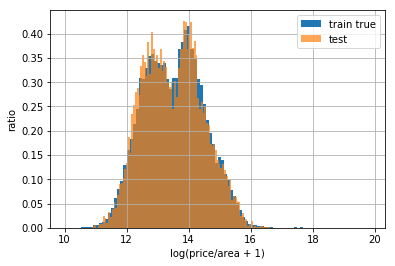

In [27]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

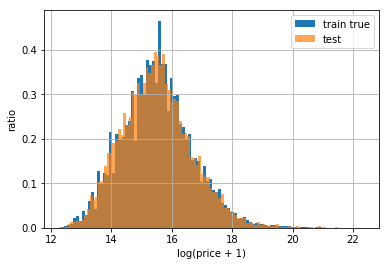

In [28]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

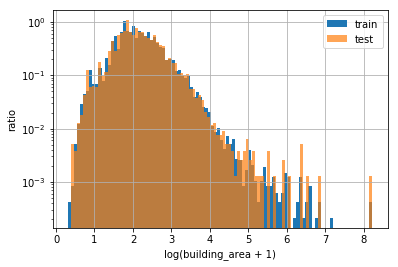

In [29]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [30]:
if is_per_area:
    test_pred_final.to_csv('output/stack_parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_{}_{}.csv'.format(stack_idx, models), index=False)

In [31]:
#a= pd.read_csv('output/model-03-lgb-feats-selection-cv.csv')
#b= pd.read_csv('output/model-03-lgb-feats-selection-test-one.csv')

In [32]:
#a.rename(columns={'building_id':'id','total_price_predict':'target'}).to_csv('opt-pred3.csv',index=False)
#b.rename(columns={'building_id':'id','total_price':'target'}).to_csv('opt-test3.csv',index=False)